# Hinge scaffolds in literature

Compare most common hinge scaffolds found by 

- Xing et al. (https://link.springer.com/article/10.1007%2Fs10822-013-9700-4)
- Mukherjee et al. (https://pubs.acs.org/doi/10.1021/acs.jcim.7b00213)

to the AP fragments in the *KinFragLib* library.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools  

from util import _read_subpocket_fragments
import klifs_utils as klifs

RDKit WARNING: [13:02:44] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
pd.options.display.max_rows = 100

## Data

### Xing et al.

In [3]:
# 10 most common fragments (ranked)
smiles_xing = [
    'C1=NC2=C(N1)C(=NC=N2)N',
    'C12C(C(CC(O1)N3C4=CC=CC=C4C5=C6C(=C7C8=CC=CC=C8N2C7=C53)CNC6=O)N)O',
    'C1=C(NN=C1)N',
    'C1=CC=NC(=N1)N',
    'C1=CC2=C(NC=C2)N=C1',
    'C1=CC=C2C(=C1)C=NN2',
    'C1=CNC2=C1C(=NC=N2)N',
    'C1=C(N=CN=C1N)N',
    'C1=CC=NC=C1',
    'C1=CNC2=NC=NC=C21'
]

### Mukherjee et al.

In [4]:
# 10 most common fragments (ranked)
smiles_mukh = [
        'C1=NC2=C(N1)C(=NC=N2)N',
        'C1=CC=NC(=N1)N',
        'C1=CC=NC=C1',
        'C12C(C(CC(O1)N3C4=CC=CC=C4C5=C6C(=C7C8=CC=CC=C8N2C7=C53)CNC6=O)N)O',
        'C1=CC=NC=C1',
        'C1=CC=NC(=N1)N',
        'C1=NC2=C(N1)C(=NC=N2)N',
        'c1ncc2nc[nH]c2n1',
        'C1=CC2=C(NC=C2)N=C1',
        '[N]2C1=NC=NC(=C1C=N2)N'
    ]

### AP fragments (KinFragLib)

In [5]:
PATH_TO_DATA = Path('../../../..') / 'KinaseFocusedFragmentLibraryData'

### Draw fragments and save to individual files

In [6]:
def draw_smiles_to_files(smiles_list, name, ranks, file_suffix, output_folder):
    
    output_folder = Path(output_folder) / 'hinge_fragments_literature'
    output_folder.mkdir(parents=True, exist_ok=True)
    
    for i, smiles in zip(ranks, smiles_list):
        mol=Chem.MolFromSmiles(smiles)
        Chem.Draw.MolToFile(mol, output_folder / f'{name}_{i}.{file_suffix}', size=(250, 250))

In [7]:
draw_smiles_to_files(smiles_xing, 'xing', range(1, len(smiles_xing)+1), 'png', PATH_TO_DATA / 'Media')
draw_smiles_to_files(smiles_mukh, 'mukh', range(1, len(smiles_mukh)+1), 'png', PATH_TO_DATA / 'Media')

## Load data

Load scaffolds/fragments as SMILES

In [8]:
def get_literature_data(smiles, author):
    
    data = pd.DataFrame(smiles, columns=['smiles'])
    PandasTools.AddMoleculeColumnToFrame(data, 'smiles')
    data[f'rank_{author}'] = np.arange(1, 11, 1)
    
    return data

### Xing et al.

In [9]:
data_xing = get_literature_data(smiles_xing, 'xing')

### Mukherjee et al.

In [10]:
data_mukh = get_literature_data(smiles_mukh, 'mukh')

### Merge literature data

In [11]:
def merge_literature_data(data_literature1, data_literature2):
    
    data_joined = data_literature1.drop('ROMol', axis=1).join(
        data_literature2.drop('ROMol', axis=1).set_index('smiles'), 
        on='smiles', 
        how='outer'
    ).reset_index(drop=True)
    PandasTools.AddMoleculeColumnToFrame(data_joined, 'smiles')
    data_joined = data_joined[['smiles', 'ROMol', 'rank_xing', 'rank_mukh']]
    return data_joined

In [12]:
data_literature = merge_literature_data(data_xing, data_mukh)

### AP fragments (KinFragLib)

In [13]:
def _get_ranks(data_ap):

    ranks = []
    
    rank = 1
    last_count = int(data_ap.count_ap[0])

    for index, row in data_ap.iterrows():

        current_count = row.count_ap

        if current_count != last_count:
            rank = row.rank_ap_uncorrected

        ranks.append(rank)

        last_count = current_count

    return ranks

In [14]:
def get_data_ap(path_to_lib):
    
    fragments_ap = _read_subpocket_fragments('AP', path_to_lib, remove_dummy=True)
    
    print('Number of fragments: ', len(fragments_ap))
    print('Number of unique fragments: ', len(fragments_ap.smiles.unique()))
    
    # Count fragments
    fragments_ap_counts = fragments_ap.smiles.value_counts(sort=True)
    fragments_ap_counts.name = 'count_ap'
    
    # Cast to DataFrame
    data_ap = pd.DataFrame(fragments_ap_counts)
    data_ap.reset_index(drop=False, inplace=True)
    data_ap.rename(columns={'index': 'smiles'}, inplace=True)
    PandasTools.AddMoleculeColumnToFrame(data_ap, 'smiles')
    
    # Set rank
    data_ap['rank_ap_uncorrected'] = np.arange(1, len(data_ap)+1, 1)
    data_ap['rank_ap'] = _get_ranks(data_ap)
    
    return data_ap

In [15]:
data_ap = get_data_ap(PATH_TO_DATA / 'FragmentLibrary')

Number of fragments:  2561
Number of unique fragments:  1115


## Compare literature scaffolds/fragments to AP fragments

In [16]:
def _get_ap_rank(data_ap, romol):
    
    for index_ap, row_ap in data_ap.iterrows():
        
        if Chem.MolToSmiles(romol) == Chem.MolToSmiles(row_ap.ROMol):
            return int(row_ap.rank_ap)

In [17]:
def _get_ap_count(data_ap, romol):
    
    for index_ap, row_ap in data_ap.iterrows():
        
        if Chem.MolToSmiles(romol) == Chem.MolToSmiles(row_ap.ROMol):
            return int(row_ap.count_ap)

In [18]:
def compare_ranks(data_literature, data_ap):
    
    data = data_literature.copy()
    data['rank_ap'] = data.apply(lambda x: _get_ap_rank(data_ap, x.ROMol), axis=1)
    data['count_ap'] = data.apply(lambda x: _get_ap_count(data_ap, x.ROMol), axis=1)
    
    return data

,smiles,ROMol,rank_xing,rank_mukh,rank_ap,count_ap
0,C1=NC2=C(N1)C(=NC=N2)N,,1.0,1.0,205.0,2.0
1,C1=NC2=C(N1)C(=NC=N2)N,,1.0,7.0,205.0,2.0
2,C12C(C(CC(O1)N3C4=CC=CC=C4C5=C6C(=C7C8=CC=CC=C...,,2.0,4.0,NaN,NaN
3,C1=C(NN=C1)N,,3.0,NaN,80.0,5.0
4,C1=CC=NC(=N1)N,,4.0,2.0,1.0,103.0
5,C1=CC=NC(=N1)N,,4.0,6.0,1.0,103.0
6,C1=CC2=C(NC=C2)N=C1,,5.0,9.0,7.0,25.0
7,C1=CC=C2C(=C1)C=NN2,,6.0,NaN,8.0,24.0
8,C1=CNC2=C1C(=NC=N2)N,,7.0,NaN,5.0,30.0
9,C1=C(N=CN=C1N)N,,8.0,NaN,80.0,5.0

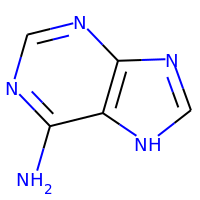
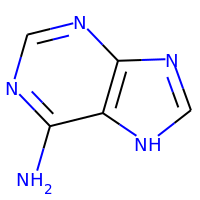
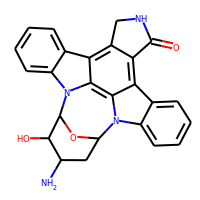
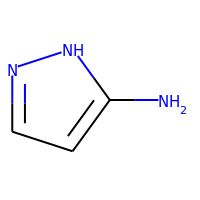
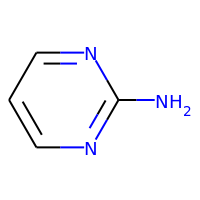
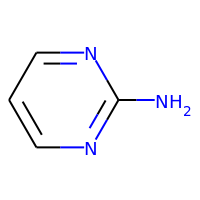
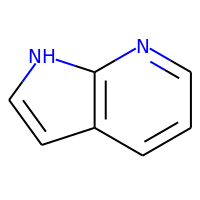
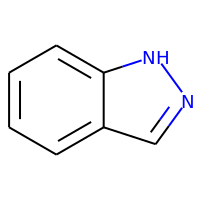
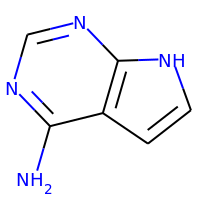
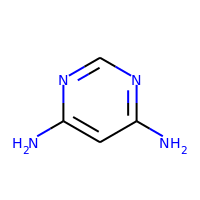
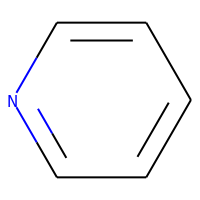
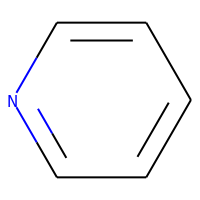
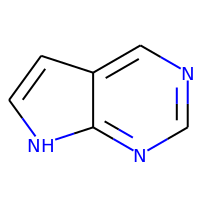
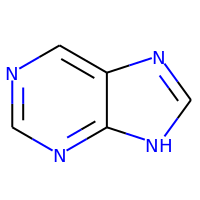
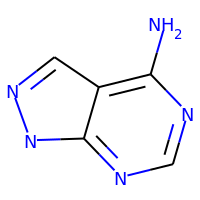

In [19]:
ranks = compare_ranks(data_literature, data_ap)
ranks

### Check adenine-containing ligands

In [20]:
fragments_ap = _read_subpocket_fragments('AP', PATH_TO_DATA / 'FragmentLibrary', remove_dummy=True)

In [21]:
adenines = fragments_ap[fragments_ap.smiles == Chem.MolToSmiles(Chem.MolFromSmiles('C1=NC2=C(N1)C(=NC=N2)N'))]

,smiles,fragment,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,klifs_code,atom.prop.subpocket,atom.prop.environment
224,Nc1ncnc2nc[nH]c12,,BTK,Tec,TK,4nwm,2P5,A,B,4nwm_altA_chainB,AP AP AP AP AP AP AP AP AP AP AP AP AP SE FP,14 14 14 14 14 14 14 14 14 14 14 5 5 na na
668,Nc1ncnc2nc[nH]c12,,CHK1,CAMKL,CAMK,2cgx,3D3,,A,2cgx_chainA,AP AP AP AP AP AP AP AP AP AP AP AP AP AP FP,14 14 14 14 14 14 14 5 5 5 14 14 14 14 na

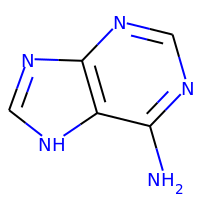
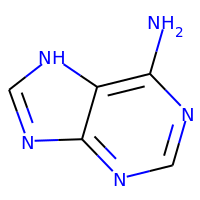

In [22]:
adenines

In [23]:
structures = klifs.remote.structures.structures_from_pdb_id(adenines.complex_pdb.tolist())
structures

,structure_ID,kinase,species,kinase_ID,pdb,alt,chain,rmsd1,rmsd2,pocket,...,bp_I_A,bp_I_B,bp_II_in,bp_II_A_in,bp_II_B_in,bp_II_out,bp_II_B,bp_III,bp_IV,bp_V
0,1595,CHK1,Human,121,2cgx,,A,0.779,2.094,QTLGEGAYGEVQLVAVKIVNIKKEICINKMLNENVVKFYGHYLFLE...,...,False,False,False,False,False,False,False,False,False,False
1,2898,BTK,Human,473,4nwm,A,B,0.819,2.158,KELGTGQFGVVKYVAIKMIEFIEEAKVMMNLSEKLVQLYGVFIITE...,...,False,False,False,False,False,False,False,False,False,False
2,2903,BTK,Human,473,4nwm,B,B,0.819,2.158,KELGTGQFGVVKYVAIKMIEFIEEAKVMMNLSEKLVQLYGVFIITE...,...,False,False,False,False,False,False,False,False,False,False
3,2917,BTK,Human,473,4nwm,B,A,0.818,2.157,KELGTGQFGVVKYVAIKMIEFIEEAKVMMNLSEKLVQLYGVFIITE...,...,False,False,False,False,False,False,False,False,False,False
4,2930,BTK,Human,473,4nwm,A,A,0.818,2.157,KELGTGQFGVVKYVAIKMIEFIEEAKVMMNLSEKLVQLYGVFIITE...,...,False,False,False,False,False,False,False,False,False,False


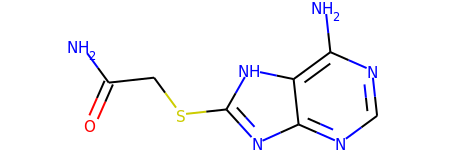

In [24]:
mol = klifs.remote.coordinates.ligand.mol2_to_rdkit_mol(1595)
AllChem.Compute2DCoords(mol)
mol

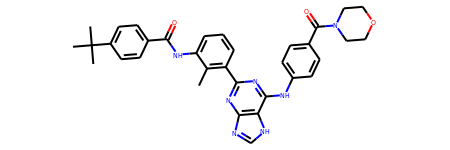

In [25]:
mol = klifs.remote.coordinates.ligand.mol2_to_rdkit_mol(2898)
AllChem.Compute2DCoords(mol)
mol

## AP fragments similar to literature fragments 

Some literature fragments do not have extact matches with AP fragments but have high similarity to AP fragments.

Here is a list of hand-picked similar AP fragments - draw molecules to file, since we need this for the manuscript appendix table.

In [26]:
similar_ap_ids = [3, 4, 10, 15]

In [27]:
draw_smiles_to_files(
    data_ap.iloc[similar_ap_ids].smiles.to_list(), 
    'ap_similar', 
    [4, 5, 11, 15],
    'png', 
    PATH_TO_DATA / 'Media'
)